In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

%matplotlib inline

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
X_train, y_train = train_data.drop('class of diagnosis', axis=1), train_data['class of diagnosis']
X_test, y_test = test_data.drop('class of diagnosis', axis=1), test_data['class of diagnosis']

# Hyperparameter tuning

In [3]:
model = RandomForestClassifier(n_estimators= 100, random_state=123, n_jobs=-1)


In [4]:
param_grid1 = {
    'n_estimators': [10, 100, 500, 1000]
    
}
grid_search1 = GridSearchCV(model, param_grid=param_grid1, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search1.fit(X_train, y_train)
model1 = grid_search1.best_estimator_
best1 = grid_search1.best_params_
print('Parameters chosen:')
print(*['{}: {}'.format(parameter, value) for parameter, value in zip(best1.keys(), best1.values())], sep='\n')

Parameters chosen:
n_estimators: 100


In [5]:
param_grid2 = {
    'max_depth': [3, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2,6,10],
    'min_samples_leaf': [1, 3, 5]
}

grid_search2 = GridSearchCV(model, param_grid=param_grid2, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search2.fit(X_train, y_train)
model2 = grid_search2.best_estimator_
best2 = grid_search2.best_params_
print('Parameters chosen:')
print(*['{}: {}'.format(parameter, value) for parameter, value in zip(best2.keys(), best2.values())], sep='\n')



Parameters chosen:
max_depth: None
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2


In [6]:
grid_model = model2
grid_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

# Model evaluation

#### Various metrics

In [7]:
print('Evaluation with 5-fold cross validation:')
for metric in ('accuracy', 'neg_log_loss', 'f1', 'roc_auc'):
    score = np.mean(cross_val_score(grid_model, X_train, y_train, scoring=metric, cv=5, n_jobs=-1))
    print('{:<10}\t {}'.format(metric, score))


Evaluation with 5-fold cross validation:
accuracy  	 0.718204843621048
neg_log_loss	 -0.5726869551372562
f1        	 0.2774436090225564
roc_auc   	 0.6949311391223155


#### Feature importance

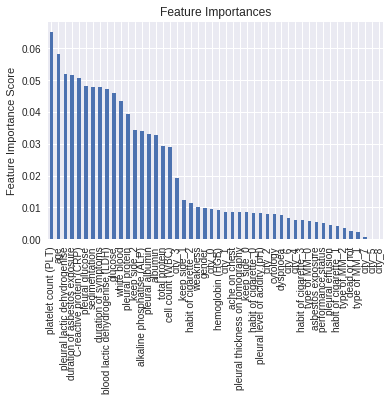

In [8]:
f_imp = pd.Series(grid_model.feature_importances_, X_train.columns)
f_imp = f_imp.sort_values(ascending=False)
f_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')


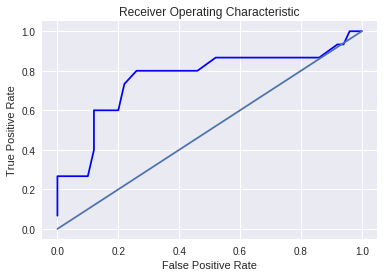

0.76200000000000001

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, grid_model.predict_proba(X_test).T[1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc_score(y_test, grid_model.predict_proba(X_test).T[1])